# Baseline

## Import

In [47]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [48]:
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [49]:
import torchvision
from torchvision import transforms

In [50]:
from torchinfo import summary
from tqdm.notebook import tqdm, trange

In [1]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn 

In [2]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

NameError: name 'torch' is not defined

## Download the data

In [94]:
from torchvision.datasets.utils import download_and_extract_archive

In [96]:
url = 'https://github.com/MVRonkin/Deep-Learning-Foundation-Course/raw/main/2024Light/ContestDataset.zip'
root_directory = os.path.join(os.getcwd(),'.')
download_and_extract_archive(url, root_directory)

100%|█████████████████████████████████████████████████████████████████| 27232148/27232148 [00:03<00:00, 8885887.38it/s]


Extracting D:\Yandex Disk\Компьютерное зрение\практики очные\Dataset_MAKE\Data\ContestDataset.zip to D:\Yandex Disk\Компьютерное зрение\практики очные\Dataset_MAKE\Data


Dataset description

In [53]:
SIZE = (32,32)
transform_ = lambda x: x.flatten()/255

transform = transforms.Compose([
    transforms.Resize(size=SIZE),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transform_,])

Let's check the contents of the data directory. The contents are:
* `train` - directory with training data set;
* `train.csv` - file with data description in `csv` format;
*  `test` - directory with the description of the closed test dataset, the results of which will be evaluated in the competition;
* `test.csv` - file with the description of the closed data set in `csv` format;
* `test_open` - directory with the description of the open test dataset, for self-checking;
* `test_open.csv` - file with the description of the open dataset in `csv` format;

Open dataset description files are two columns mapping the file name to the file label. In a closed dataset, the description is a given order of file names without labels.

Translated with DeepL.com (free version)

In [54]:
os.listdir('ContestDataset')

['test', 'test.csv', 'test_open', 'test_open.csv', 'train', 'train.csv']

Additionally, let's open each description file to make sure it has the correct format.

In [55]:
csv = pd.read_csv(os.path.join('ContestDataset','train.csv'))
csv.head(1)

,file_name,class
0,n03365231_2651.png,airplane


In [56]:
csv = pd.read_csv(os.path.join('ContestDataset','test_open.csv'))
csv.head(1)

,file_name,class
0,n04308397_5230.png,airplane


In [57]:
csv = pd.read_csv(os.path.join('ContestDataset','test.csv'))
csv.head(1)

,file_name
0,cifar10-train-25538.png


You can see that the classes are given their names. We will need to assign numeric labels to the classes.

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
csv = pd.read_csv(os.path.join('ContestDataset','test_open.csv'))
print(np.unique(le.fit_transform(csv['class'])), csv['class'].unique() )

[0 1 2 3 4] ['airplane' 'automobile' 'bird' 'cat' 'deer']


Now let's create a class to work with data. The class is a typical `Dataset class` of `PyTorch`.

Constructor arguments:
* `image_dir` - path to the directory with images;
* `data_path` - path to the file with the description of isorbations;
* `transform` - set of image transformations in `torchvision.transforms` format;
* `le` - the given label encoder (Note that there could be a more general class `target_transform` here.

The most important part of the class is the `__getitem__` method, which allows you to work with instances of the class as a list, accessed by index.  

The method returns a pair `(x,y)`, where `x` is the image and `y` is either the label, or the file name if there is no label.

In [76]:
class ContestDataset(Dataset):
    def __init__(self, image_dir = 'train', data_path = 'train.csv', transform=None, le = False):
        
        self.image_dir = image_dir
        
        csv = pd.read_csv(data_path)      
        
        self.fnames = csv['file_name']        

        self.transform = transform
        
        self.le = le
        
        if 'class' in csv.columns:
            if self.le == False:
                self.le = LabelEncoder()
                self.le.fit(csv['class'])
                
            self.class_names = list(csv['class'].unique())                            
            self.labels = self.le.transform(csv['class'])
            self.labels_exist = True

        else:
            self.labels = None
            self.labels_exist = False

    
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir,self.fnames[idx]) ) 
#         img = np.asarray(img, dtype=float) 

        if self.transform:
            img = self.transform(img)
        
        if self.labels_exist:
            label = self.labels[idx] 
        else:
            label = self.fnames[idx]

        return img, label

5000
torch.Size([1024]) 0


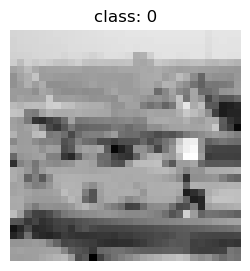

In [77]:
train_data =  ContestDataset(image_dir = os.path.join('ContestDataset','train'), 
                             data_path = os.path.join('ContestDataset','train.csv'),                              
                             transform=transform, le = le)
print(len(train_data))
x,y = train_data[8]
print(x.shape, y)
plt.figure(figsize=(3,3));plt.imshow(x.reshape(*SIZE), cmap='gray'); plt.title('class: '+str(y)); plt.axis('off'); plt.show();

2500
torch.Size([1024])


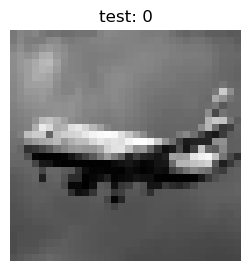

In [78]:
test_data =  ContestDataset(image_dir = os.path.join('ContestDataset','test_open'), 
                            data_path = os.path.join('ContestDataset','test_open.csv'), 
                            transform=transform, le = le)

print(len(test_data))
x,y = test_data[8]
print(x.shape)
plt.figure(figsize=(3,3));plt.imshow(x.reshape(*SIZE), cmap='gray'); plt.title('test: '+str(y)); plt.axis('off'); plt.show();

2500
torch.Size([1024])


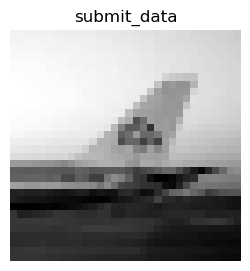

In [79]:
submit_data =  ContestDataset(image_dir = os.path.join('ContestDataset','test'), 
                              data_path = os.path.join('ContestDataset','test.csv'), 
                              transform=transform, le = le)

print(len(submit_data))
x, _ = submit_data[8]
print(x.shape)
plt.figure(figsize=(3,3));plt.imshow(x.reshape(*SIZE), cmap='gray'); plt.title('submit_data'); plt.axis('off'); plt.show();

TRAIN 5000 shape torch.Size([1024])
SUBMIT 2500 shape torch.Size([1024])


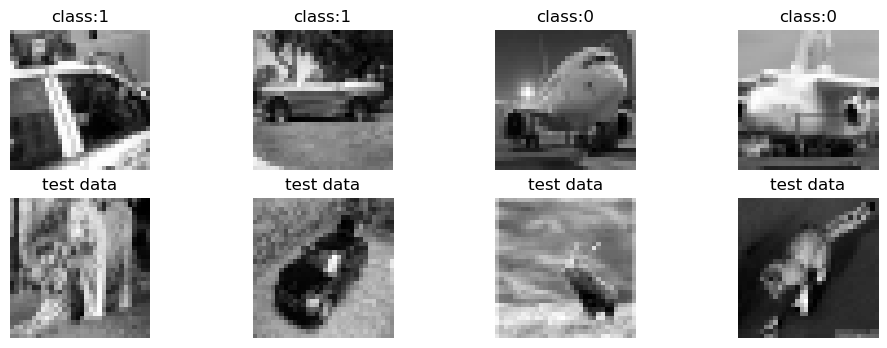

In [80]:
fig, axs = plt.subplots(2,4, figsize=(12,4));

x,y = train_data[0]

print('TRAIN', len(train_data), 'shape', x.shape)
for i,idx in enumerate(np.random.randint(0, len(train_data), 4)):  
    x,y = train_data[idx]    
    axs[0,i].imshow(x.reshape(*SIZE), cmap='gray'); 
    axs[0,i].axis('off'); 
    axs[0,i].set_title('class:'+str(y)); 

x, _ = submit_data[0]
print('SUBMIT', len(submit_data), 'shape', x.shape)
for i,idx in enumerate(np.random.randint(0, len(submit_data), 4)):  
    x, _ = submit_data[idx]    
    axs[1,i].imshow(x.reshape(*SIZE), cmap='gray'); 
    axs[1,i].axis('off'); 
    axs[1,i].set_title('test data'); 

plt.show();

## Validation part

In [81]:
TRAIN_RATIO = 0.8

n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f"Training data size : {len(train_data)}, Validation data size : {len(valid_data)}, Test data size : {len(test_data)}")

Training data size : 4000, Validation data size : 1000, Test data size : 2500


## DataLoader for batch

Note that currently there are 4 data sets, and accordingly 4 data loaders are created:
* `train_loader` - training data;
* `val_loader` - validation data;
* `test_loader` - test data (open self-test);
* `submit_loader` - test data for submission (closed test).

In [82]:
import torch.utils.data as data

BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)


submit_loader = data.DataLoader(submit_data,
                                batch_size=BATCH_SIZE)
 
print(f"Training data batches : {len(train_loader)}, Validation data batches : {len(val_loader)}, Test data batches : {len(test_loader)}, Submit data batches : {len(test_loader)}")

Training data batches : 63, Validation data batches : 16, Test data batches : 40, Submit data batches : 40


In [83]:
images, label =  next(iter(val_loader))
images.shape, label.shape


(torch.Size([64, 1024]), torch.Size([64]))

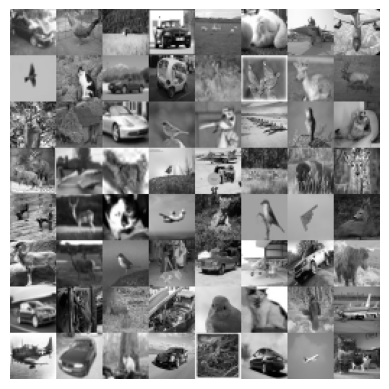

(torch.Size([64, 1, 32, 32]), torch.Size([3, 256, 256]), (256, 256, 3))

In [84]:
images = images.reshape(-1,1,*SIZE)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape

## Baseline model

In [85]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(SIZE[0]*SIZE[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, 11)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)+ x) 
        x = self.fc_out(x)
        return x
        

In [86]:
model = Model()

summary(model,input_size =(1,SIZE[0]*SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 11]                   --
├─Linear: 1-1                            [1, 128]                  131,200
├─Linear: 1-2                            [1, 64]                   8,256
├─Linear: 1-3                            [1, 64]                   4,160
├─Linear: 1-4                            [1, 11]                   715
Total params: 144,331
Trainable params: 144,331
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.58
Estimated Total Size (MB): 0.58

# Training

Функции описывают минимальный рабочий вариант обучения и проверки качества работы нейронной сети.

In [87]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device).float(), y.to(device).long()

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x) #model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device).float(), y.to(device).long()

            y_pred = model.forward(x) #model(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = 10, 
        device='cpu', scheduler = None,  path_best = 'best_model.pt', verbose = True):
    
    best_valid_loss = float('inf')
    history = {'train_loss':np.zeros(epochs),
               'valid_loss':np.zeros(epochs),
               'train_acc':np.zeros(epochs),
               'valid_acc':np.zeros(epochs)}
    
    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)
        
        if scheduler != None:
            scheduler.step()
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)
        
        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)       
    
        if verbose == True:
            if epoch%2 == 1:    # print every 2 epochs:
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
                f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 
  
        history['train_loss'][epoch] = train_loss 
        history['valid_loss'][epoch] = valid_loss 
        history['train_acc'][epoch] = train_acc 
        history['valid_acc'][epoch] = valid_acc 
    return history

# Initialization

In [88]:
model = Model()
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr = 5e-3)


def calculate_accuracy(y_pred, y):
    with torch.no_grad():
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
    return acc

metric = calculate_accuracy

In [89]:
fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = 10, device=device, verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 1.715 | Train Acc: 20.91%  | Val. Loss: 1.617 | Val. Acc: 19.80%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.618 | Train Acc: 20.34%  | Val. Loss: 1.611 | Val. Acc: 19.80%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.601 | Train Acc: 23.49%  | Val. Loss: 1.576 | Val. Acc: 25.02%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 1.574 | Train Acc: 27.23%  | Val. Loss: 1.543 | Val. Acc: 30.21%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.543 | Train Acc: 29.17%  | Val. Loss: 1.508 | Val. Acc: 32.58%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.502 | Train Acc: 33.53%  | Val. Loss: 1.476 | Val. Acc: 35.20%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 1.491 | Train Acc: 34.28%  | Val. Loss: 1.508 | Val. Acc: 30.92%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 1.488 | Train Acc: 34.60%  | Val. Loss: 1.488 | Val. Acc: 33.75%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 1.473 | Train Acc: 35.79%  | Val. Loss: 1.452 | Val. Acc: 36.15%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 1.468 | Train Acc: 36.63%  | Val. Loss: 1.461 | Val. Acc: 35.43%


# Testing

In [74]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.448 | Test Acc: 35.23%


# Submission report

There is a special separate function `submit` whose result is a `DataFrame` with two columns:
* `file_name` - file name from a closed dataset
* `class` - predicted class label (in number format from 0 and higher).

In [75]:
def submit(model, dataloader, device):

    df = pd.DataFrame(columns = ('file_name','class'))
    model.eval()

    with torch.inference_mode():
        
        for x,y in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device).float()
            y_pred = model.forward(x)
            cls    = list(y_pred.argmax(1, keepdim=False).data.numpy())
            
            df = pd.concat([df,pd.DataFrame({'file_name':y,'class':cls})], ignore_index = True)

    return df.reset_index()

In [44]:
df_ = submit(model, submit_loader, device)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Saving

<code style="color:red">__Plase name file you name__ </code>

In [92]:
path_submit = 'submit.csv'

df_.to_csv(path_submit, index = False )

print('FULL PATH:  \n', os.path.join(os.getcwd(), path_submit) )

FULL PATH:  
 D:\Yandex Disk\Компьютерное зрение\практики очные\Dataset_MAKE\submit.csv


Cheking

In [46]:
pd.read_csv('submit.csv')

,index,file_name,class
0,0,cifar10-train-25538.png,0
1,1,cifar10-train-1086.png,0
2,2,cifar10-train-12192.png,2
3,3,cifar10-train-43783.png,2
4,4,n03596543_2495.png,0
...,...,...,...
2495,2495,n02430045_5648.png,3
2496,2496,cifar10-train-2896.png,2
2497,2497,n02439398_4337.png,2
2498,2498,cifar10-test-1945.png,3
